# Import Packages

In [1]:
import numpy as np
import math
import time
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt
from scipy.stats import poisson
import gym
import hiive.mdptoolbox 
import hiive.mdptoolbox.mdp
import hiive.mdptoolbox.example
import mdptoolbox, mdptoolbox.example
import lrl
from lrl import environments, solvers
from lrl.utils import plotting

# Forest Management

In [2]:
def plot_simple_data(x_var, y_var, x_label, y_label, title, figure_size=(4,3)):
    plt.rcParams["figure.figsize"] = figure_size
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.plot(x_var, y_var, 'o-')
    plt.show()

def plot_data_legend(x_vars, x_label, all_y_vars, y_var_labels, y_label, title, y_bounds=None):
    colors = ['red','orange','black','green','blue','violet']
    plt.rcParams["figure.figsize"] = (4,3)

    i = 0
    for y_var in all_y_vars:
#         if i == 2: # don't plot when i = 1 for cv
#             x_vars = x_vars[1:]
        plt.plot(x_vars, y_var, 'o-', color=colors[i % 6], label=y_var_labels[i])
        i += 1
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    if y_bounds != None:
        plt.ylim(y_bounds)
    leg = plt.legend()
    plt.show()

In [3]:
def make_time_array(run_stats, variables):
    cumulative_sum = 0
    times = []
    output_dict = {v:[] for v in variables}
    output_dict["times"] = times
    for result in run_stats:
        times.append(result["Time"])
        for v in result:
            if v in variables:
                output_dict[v].append(result[v])
    return output_dict

In [4]:
def compose_discounts(significant_digits):
    prev_discount = 0
    discounts = []
    for i in range(1,significant_digits + 1):
        discounts.append(round(prev_discount + 9*(10**-i),i))
        prev_discount = discounts[-1]
    return discounts

def run_forest(solver, states, discounts, epsilons, probability=0.1, max_iter=10):
    experiments = [] #num states, probability, discount, time, iterations, policy
    for s in states:
        for e in epsilons:
            for d in discounts:
                entry = {}
                P, R = hiive.mdptoolbox.example.forest(S=s, p=probability)
                #start_time = time.time()
                args = {"transitions":P, "reward":R, "gamma":d, "epsilon":e, "max_iter":max_iter, "skip_check":True}
                mdp = solver(args)
                mdp.run()
                #end_time = time.time()
                entry["time"] = mdp.time
                entry["iterations"] = mdp.iter
                entry["policy"] = mdp.policy
                entry["num_states"] = s
                entry["probability"] = probability
                entry["discount"] = d
                entry["epsilon"] = e
                entry["run_stats"] = mdp.run_stats
                experiments.append(entry)
    return experiments

In [5]:
states = [10**s for s in range(2,4)]
discounts = compose_discounts(5)
epsilons = [0.01, 0.005, 0.001]


fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons)

In [6]:
fm_value_iteration_results
def print_training_results(results):
    for result in fm_value_iteration_results:
        print("\nNew result #################")
        for key in result:
            if key != "policy":
                print("{0}: {1}".format(key,result[key]))
def collect_training_results(results, keys, to_print=True):
    output_dict = {key:[] for key in keys}
    for result in results:
        if to_print: print("\nNew result #################")
        for key in result:
            if key in keys:
                if to_print: print("{0}: {1}".format(key,result[key]))
                output_dict[key].append(result[key])
    return output_dict

## Number of States vs Training time on Value Iteration and Policy Iteration

In [7]:
states = [k*10**pwr for pwr in range(2,3) for k in range(1,10)]
states += [1000]
states += [1000 + s for s in (states) ]

discounts = [0.9]
epsilons = [0.1]

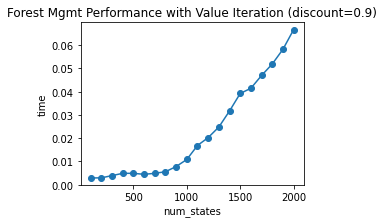

In [8]:
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons)  
#print_training_results(fm_value_iteration_results)
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "num_states"], to_print=False)
fm_vi_iters_num_states = collect_training_results(fm_value_iteration_results, ["iterations", "num_states"], to_print=False)
plot_simple_data(fm_vi_time_num_states["num_states"], fm_vi_time_num_states["time"], "num_states", "time", "Forest Mgmt Performance with Value Iteration (discount=0.9)")

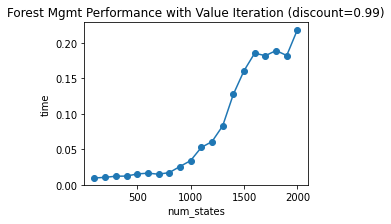

In [9]:
discounts = [0.99]
epsilons = [0.1]

fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons)  
#print_training_results(fm_value_iteration_results)
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "num_states"], to_print=False)
fm_vi_iters_num_states = collect_training_results(fm_value_iteration_results, ["iterations", "num_states"], to_print=False)
plot_simple_data(fm_vi_time_num_states["num_states"], fm_vi_time_num_states["time"], "num_states", "time", "Forest Mgmt Performance with Value Iteration (discount=0.99)")

## Solving FM with 2000 states using value iteration

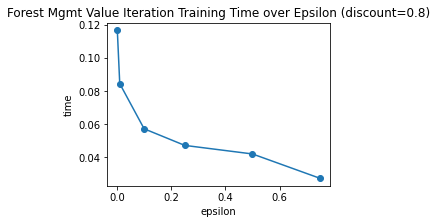

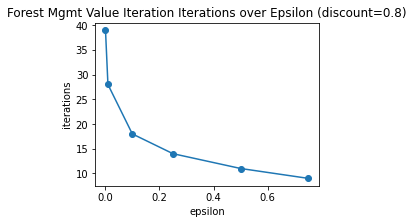

In [10]:
states = [2000]
discounts = [0.8]
epsilons = [0.75,0.5,0.25,0.1,0.01, 0.001]
fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons, probability=0.0001, max_iter=10**2)  
#print_training_results(fm_value_iteration_results)
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "epsilon", "iterations"], to_print=False)
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["time"], "epsilon", "time", "Forest Mgmt Value Iteration Training Time over Epsilon (discount=0.8)")
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["iterations"], "epsilon", "iterations", "Forest Mgmt Value Iteration Iterations over Epsilon (discount=0.8)")

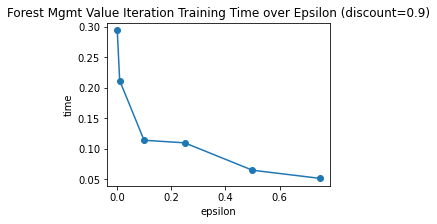

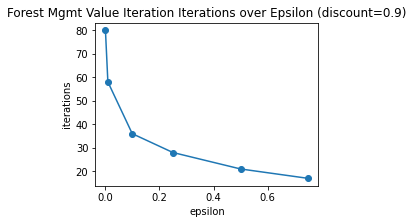

In [11]:
states = [2000]
discounts = [0.9]
epsilons = [0.75,0.5,0.25,0.1,0.01, 0.001]
fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons, probability=0.0001, max_iter=10**2)  
#print_training_results(fm_value_iteration_results)
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "epsilon", "iterations"], to_print=False)
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["time"], "epsilon", "time", "Forest Mgmt Value Iteration Training Time over Epsilon (discount=0.9)")
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["iterations"], "epsilon", "iterations", "Forest Mgmt Value Iteration Iterations over Epsilon (discount=0.9)")

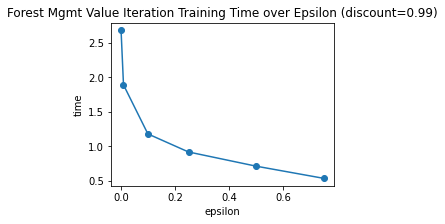

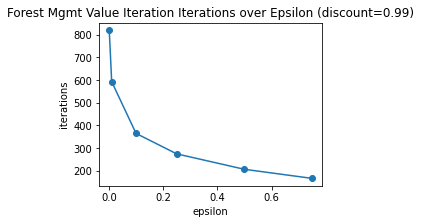

In [12]:
states = [2000]
discounts = [0.99]
epsilons = [0.75,0.5,0.25,0.1,0.01, 0.001]
fm_value_iteration = lambda dict_args: hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_value_iteration_results = run_forest(fm_value_iteration, states, discounts, epsilons, probability=0.0001, max_iter=10**2)  
#print_training_results(fm_value_iteration_results)
fm_vi_time_num_states = collect_training_results(fm_value_iteration_results, ["time", "epsilon", "iterations"], to_print=False)
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["time"], "epsilon", "time", "Forest Mgmt Value Iteration Training Time over Epsilon (discount=0.99)")
plot_simple_data(fm_vi_time_num_states["epsilon"], fm_vi_time_num_states["iterations"], "epsilon", "iterations", "Forest Mgmt Value Iteration Iterations over Epsilon (discount=0.99)")

P: 
array([[0.01, 0.99, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.99, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.01, 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99]])
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

R: 
array([0., 0., 0., ..., 0., 0., 4.])
array([0., 1., 1., ..., 1., 1., 2.])

max mean v 5.34393582302352


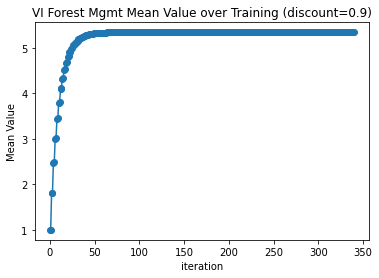

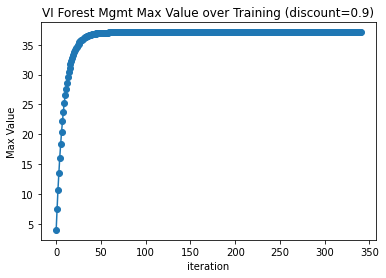

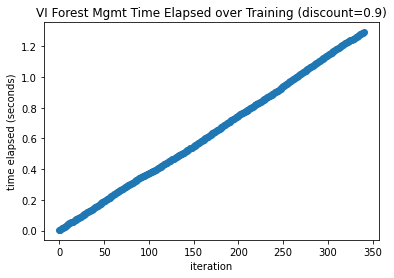

In [13]:
P_pi_fm, R_pi_fm = hiive.mdptoolbox.example.forest(S=2000, p=0.01)
dict_args = {"transitions":P_pi_fm, "reward":R_pi_fm, "gamma":0.9,"epsilon":10**(-50), "max_iter":10**5, "skip_check":True}
fm_vi_mdp = hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_vi_mdp.run()
print(fm_vi_mdp)
fm_vi_mdp_curated_results = make_time_array(fm_vi_mdp.run_stats, ["Mean V", "Max V"])
num_iters = len(fm_vi_mdp_curated_results["Mean V"])
print("max mean v", max(fm_vi_mdp_curated_results["Mean V"]))
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Forest Mgmt Mean Value over Training (discount=0.9)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Forest Mgmt Max Value over Training (discount=0.9)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Forest Mgmt Time Elapsed over Training (discount=0.9)", figure_size=(6,4))

P: 
array([[0.01, 0.99, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.99, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.01, 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99]])
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

R: 
array([0., 0., 0., ..., 0., 0., 4.])
array([0., 1., 1., ..., 1., 1., 2.])

max mean v 53.10862528399213


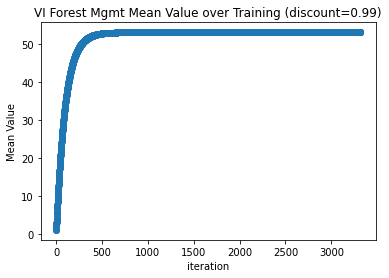

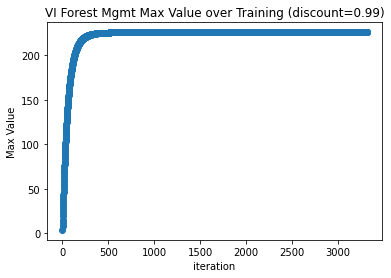

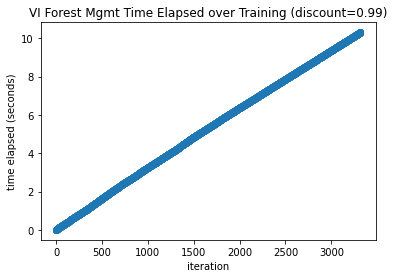

In [14]:
P_pi_fm, R_pi_fm = hiive.mdptoolbox.example.forest(S=2000, p=0.01)
dict_args = {"transitions":P_pi_fm, "reward":R_pi_fm, "gamma":0.99,"epsilon":10**(-50), "max_iter":10**5, "skip_check":True}
fm_vi_mdp = hiive.mdptoolbox.mdp.ValueIteration(**dict_args)
fm_vi_mdp.run()
print(fm_vi_mdp)
fm_vi_mdp_curated_results = make_time_array(fm_vi_mdp.run_stats, ["Mean V", "Max V"])
num_iters = len(fm_vi_mdp_curated_results["Mean V"])
print("max mean v", max(fm_vi_mdp_curated_results["Mean V"]))
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["Mean V"], 
                 "iteration", "Mean Value", "VI Forest Mgmt Mean Value over Training (discount=0.99)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["Max V"], 
                 "iteration", "Max Value", "VI Forest Mgmt Max Value over Training (discount=0.99)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_vi_mdp_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "VI Forest Mgmt Time Elapsed over Training (discount=0.99)", figure_size=(6,4))

## Solving FM with 2000 states using policy iteration

P: 
array([[0.01, 0.99, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.99, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.01, 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99]])
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

R: 
array([0., 0., 0., ..., 0., 0., 4.])
array([0., 1., 1., ..., 1., 1., 2.])



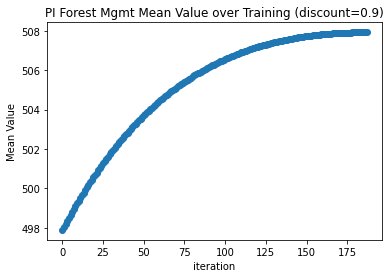

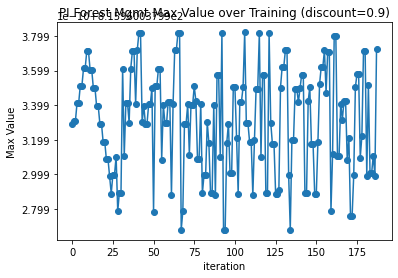

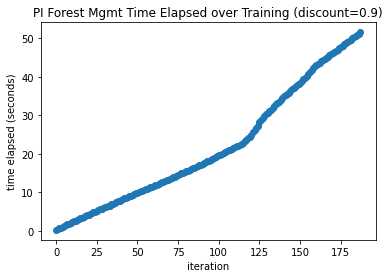

In [15]:
P_pi_fm, R_pi_fm = hiive.mdptoolbox.example.forest(S=2000, p=0.01)
dict_args = {"transitions":P_pi_fm, "reward":R_pi_fm, "gamma":0.9, "epsilon":0.1, "max_iter":10**3}
fm_pi_mdp = hiive.mdptoolbox.mdp.PolicyIteration(P_pi_fm, R_pi_fm, 0.999, max_iter = 5*10**2, skip_check=True)
fm_pi_mdp.run()
print(fm_pi_mdp)
fm_pi_mdp_curated_results = make_time_array(fm_pi_mdp.run_stats, ["Mean V", "Max V"])
num_iters = len(fm_pi_mdp_curated_results["Mean V"])
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["Mean V"], 
                 "iteration", "Mean Value", "PI Forest Mgmt Mean Value over Training (discount=0.9)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["Max V"], 
                 "iteration", "Max Value", "PI Forest Mgmt Max Value over Training (discount=0.9)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "PI Forest Mgmt Time Elapsed over Training (discount=0.9)", figure_size=(6,4))

P: 
array([[0.01, 0.99, 0.  , ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.99, ..., 0.  , 0.  , 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.  ],
       ...,
       [0.01, 0.  , 0.  , ..., 0.  , 0.99, 0.  ],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99],
       [0.01, 0.  , 0.  , ..., 0.  , 0.  , 0.99]])
array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.]])

R: 
array([0., 0., 0., ..., 0., 0., 4.])
array([0., 1., 1., ..., 1., 1., 2.])



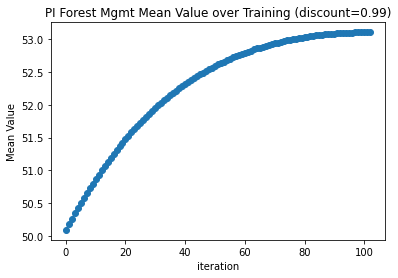

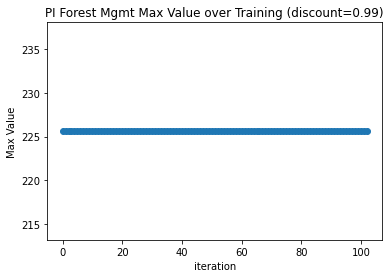

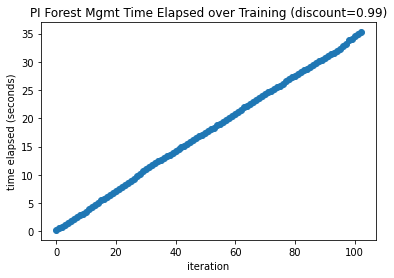

In [16]:
P_pi_fm, R_pi_fm = hiive.mdptoolbox.example.forest(S=2000, p=0.01)
dict_args = {"transitions":P_pi_fm, "reward":R_pi_fm, "gamma":0.99, "epsilon":0.1, "max_iter":10**3}
fm_pi_mdp = hiive.mdptoolbox.mdp.PolicyIteration(P_pi_fm, R_pi_fm, 0.99, max_iter = 5*10**2, skip_check=True)
fm_pi_mdp.run()
print(fm_pi_mdp)
fm_pi_mdp_curated_results = make_time_array(fm_pi_mdp.run_stats, ["Mean V", "Max V"])
num_iters = len(fm_pi_mdp_curated_results["Mean V"])
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["Mean V"], 
                 "iteration", "Mean Value", "PI Forest Mgmt Mean Value over Training (discount=0.99)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["Max V"], 
                 "iteration", "Max Value", "PI Forest Mgmt Max Value over Training (discount=0.99)", figure_size=(6,4))
plot_simple_data([i for i in range(num_iters)], fm_pi_mdp_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "PI Forest Mgmt Time Elapsed over Training (discount=0.99)", figure_size=(6,4))

In [17]:
print("max mean v pi", max(fm_pi_mdp_curated_results["Mean V"]))
neq = []
for i in range(len(fm_vi_mdp.policy)):
    if fm_vi_mdp.policy[i] != fm_pi_mdp.policy[i]:
        neq.append(i)
len(neq)
sum(fm_vi_mdp.policy) < sum(fm_pi_mdp.policy)
sum(fm_pi_mdp.policy)
neq

max mean v pi 53.108625283992424


[]

In [18]:
print("max mean v pi", max(fm_pi_mdp_curated_results["Mean V"]))
neq = []
for i in range(len(fm_vi_mdp.policy)):
    if fm_vi_mdp.policy[i] != fm_pi_mdp.policy[i]:
        neq.append(i)
len(neq)
sum(fm_vi_mdp.policy)

max mean v pi 53.108625283992424


1896

## Solve FM with 2000 states using Q-Learning

In [19]:
P, R = hiive.mdptoolbox.example.forest(S=2000, p=0.01)
st = time.time()
fm_q_mdp = hiive.mdptoolbox.mdp.QLearning(P, R, 0.9, epsilon=0.1,epsilon_decay=0.95, n_iter=1000000, alpha=0.1, alpha_decay = 0.99, skip_check=True)
fm_q_mdp.run()
end = time.time()
end-st
# fm_q_mdp.policy

224.79688024520874

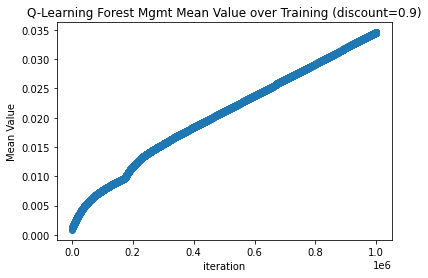

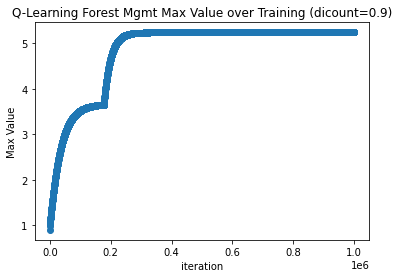

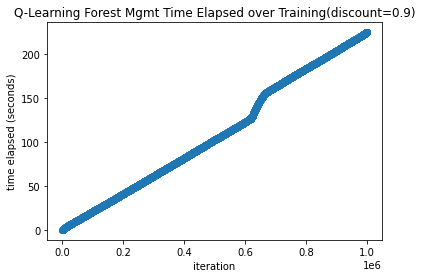

In [20]:
fm_q_curated_results = make_time_array(fm_q_mdp.run_stats, ["Mean V", "Max V", "Iteration"])
num_iters = len(fm_q_curated_results["Mean V"])
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Mean V"], 
                 "iteration", "Mean Value", "Q-Learning Forest Mgmt Mean Value over Training (discount=0.9)", figure_size=(6,4))
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Max V"], 
                 "iteration", "Max Value", "Q-Learning Forest Mgmt Max Value over Training (dicount=0.9)", figure_size=(6,4))
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "Q-Learning Forest Mgmt Time Elapsed over Training(discount=0.9)", figure_size=(6,4))

In [21]:
P, R = hiive.mdptoolbox.example.forest(S=2000, p=0.01)
st = time.time()
fm_q_mdp = hiive.mdptoolbox.mdp.QLearning(P, R, 0.99, epsilon=0.1,epsilon_decay=0.95, n_iter=1000000, alpha=0.1, alpha_decay = 0.99, skip_check=True)
fm_q_mdp.run()
end = time.time()
end-st
# fm_q_mdp.policy

201.88971400260925

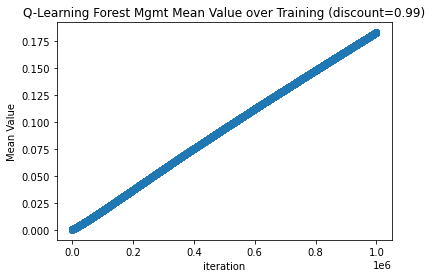

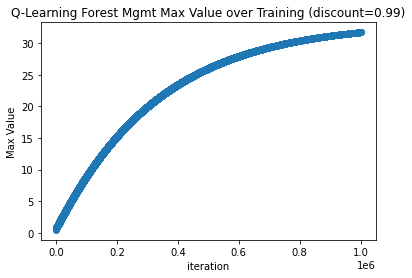

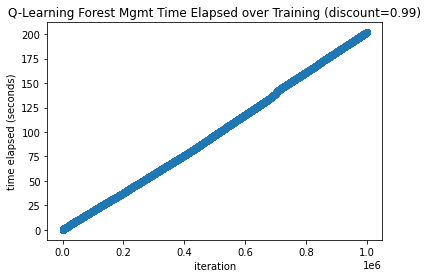

In [22]:
fm_q_curated_results = make_time_array(fm_q_mdp.run_stats, ["Mean V", "Max V", "Iteration"])
num_iters = len(fm_q_curated_results["Mean V"])
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Mean V"], 
                 "iteration", "Mean Value", "Q-Learning Forest Mgmt Mean Value over Training (discount=0.99)", figure_size=(6,4))
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["Max V"], 
                 "iteration", "Max Value", "Q-Learning Forest Mgmt Max Value over Training (discount=0.99)", figure_size=(6,4))
plot_simple_data(fm_q_curated_results["Iteration"], fm_q_curated_results["times"], 
                 "iteration", "time elapsed (seconds)", "Q-Learning Forest Mgmt Time Elapsed over Training (discount=0.99)", figure_size=(6,4))

## Initialization of an 8x8 Frozen Lake environment

<AxesSubplot:>

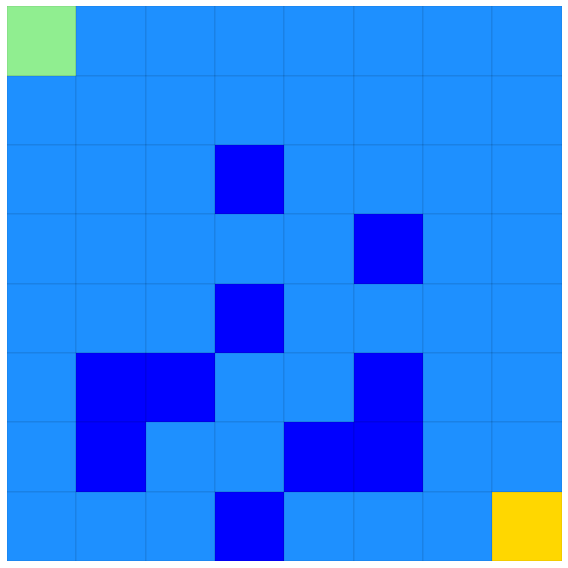

In [23]:
lake = environments.frozen_lake.RewardingFrozenLakeEnv(map_name='8x8', is_slippery=True)
plotting.plot_env(env=lake)

## Solve with value iteration

In [24]:
lake_vi = solvers.ValueIteration(env=lake)
lake_vi.iterate_to_convergence()

In [25]:
scoring_data = lake_vi.score_policy(iters=500)
print(f'type(scoring_data) = {type(scoring_data)}')
scoring_data_df = scoring_data.to_dataframe(include_episodes=True)
scoring_data_df.head(3)

type(scoring_data) = <class 'lrl.data_stores.data_stores.EpisodeStatistics'>


,episode_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction,episodes
0,0,0.86,16,True,0.860000,0.860,0.000000,0.86,0.86,16.000000,16.0,0.000000,16,16,1.0,"[0, 1, 1, 2, 3, 4, 5, 6, 14, 22, 23, 31, 39, 4..."
1,1,0.87,15,True,0.865000,0.865,0.005000,0.86,0.87,15.500000,15.5,0.500000,15,16,1.0,"[0, 1, 2, 3, 4, 5, 6, 14, 22, 23, 31, 39, 47, ..."
2,2,0.72,30,True,0.816667,0.860,0.068475,0.72,0.87,20.333333,16.0,6.847546,15,30,1.0,"[0, 1, 2, 3, 4, 12, 4, 5, 5, 6, 14, 15, 23, 22..."


In [26]:
scoring_data_df.tail(3)

,episode_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction,episodes
497,497,0.86,16,True,0.804016,0.81,0.044595,0.57,0.87,21.598394,21.0,4.459474,15,45,1.0,"[0, 0, 1, 2, 3, 4, 5, 6, 14, 22, 23, 31, 39, 4..."
498,498,0.83,19,True,0.804068,0.81,0.044565,0.57,0.87,21.593186,21.0,4.456518,15,45,1.0,"[0, 8, 0, 1, 2, 3, 4, 5, 13, 14, 22, 14, 22, 2..."
499,499,0.81,21,True,0.804080,0.81,0.044521,0.57,0.87,21.592000,21.0,4.452138,15,45,1.0,"[0, 1, 2, 3, 3, 4, 4, 5, 6, 14, 22, 14, 22, 14..."


In [27]:
print(f'The reward obtained in the 499th episode was {scoring_data_df.loc[499, "reward"]}')
print(f'The mean reward obtained in the 0-499th episode (inclusive) was {scoring_data_df.loc[499, "reward_mean"]}')

The reward obtained in the 499th episode was 0.8099999999999999
The mean reward obtained in the 0-499th episode (inclusive) was 0.8040799999999999


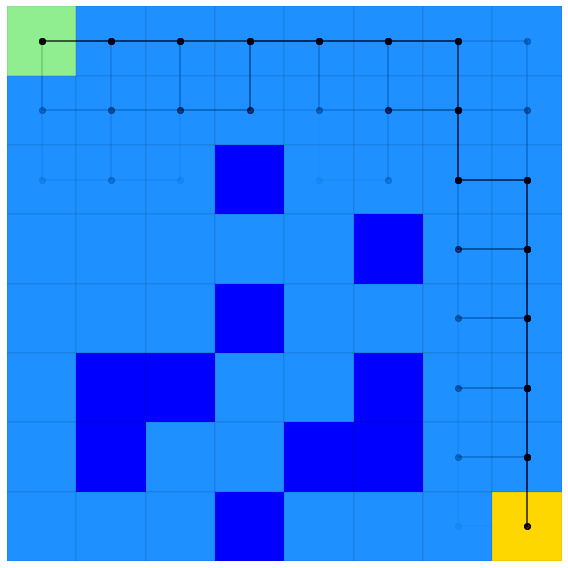

In [28]:
ax_episodes = plotting.plot_episodes(episodes=scoring_data.episodes, env=lake, max_episodes=100, )

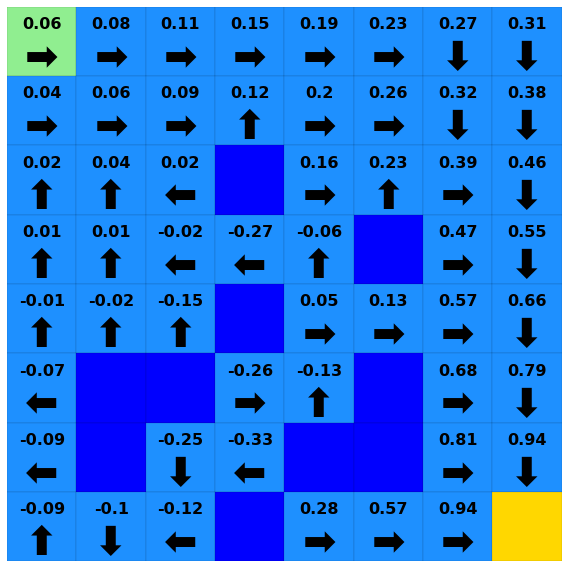

In [29]:
ax_results = plotting.plot_solver_results(env=lake, solver=lake_vi)

## Solve with Policy Iteration

In [30]:
lake_pi = solvers.PolicyIteration(env=lake)
lake_pi.iterate_to_convergence()

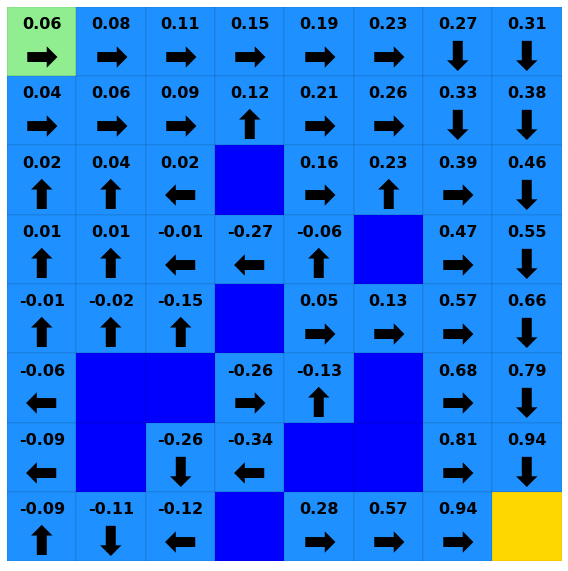

In [31]:
ax_results = plotting.plot_solver_results(env=lake, solver=lake_pi)

## Comparing Value Iteration with Policy Iteration

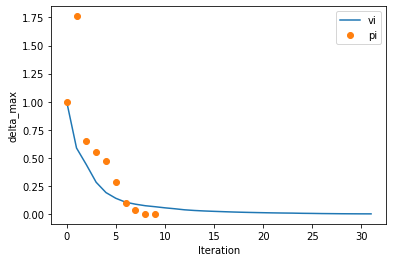

In [32]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(lake_vi, label='vi')

# Or going a little deeper into the API, with style being passed to matplotlib's plot function...
ax = plotting.plot_solver_convergence_from_df(lake_pi.iteration_data.to_dataframe(), y='delta_max', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

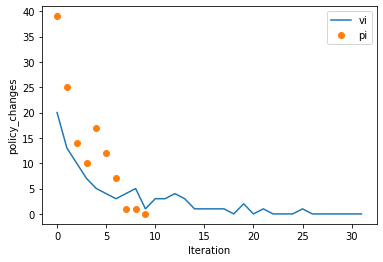

In [33]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(lake_vi, y='policy_changes', label='vi')

# Or going a little deeper into the API...
ax = plotting.plot_solver_convergence_from_df(lake_pi.iteration_data.to_dataframe(), y='policy_changes', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

Total solution time for Value Iteration (excludes any scoring time):  0.04s
Total solution time for Policy Iteration (excludes any scoring time): 0.08s


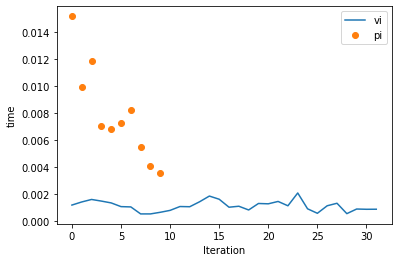

In [34]:
# (these are simple convenience functions for plotting, basically just recipes.  See the plotting API)
# We can pass the solver..
ax = plotting.plot_solver_convergence(lake_vi, y='time', label='vi')

# Or going a little deeper into the API...
ax = plotting.plot_solver_convergence_from_df(lake_pi.iteration_data.to_dataframe(), y='time', x='iteration', ax=ax, label='pi', ls='', marker='o')

ax.legend()

print(f'Total solution time for Value Iteration (excludes any scoring time):  {lake_vi.iteration_data.to_dataframe().loc[:, "time"].sum():.2f}s')
print(f'Total solution time for Policy Iteration (excludes any scoring time): {lake_pi.iteration_data.to_dataframe().loc[:, "time"].sum():.2f}s')

## Solve with Q-learning

In [35]:
# Let's be explicit with our QLearning settings for alpha and epsilon
alpha = 0.1  # Constant alpha during learning

# Decay function for epsilon (see QLearning() and decay_functions() in documentation for syntax)
# Decay epsilon linearly from 0.2 at timestep (iteration) 0 to 0.05 at timestep 1500, 
# keeping constant at 0.05 for ts>1500
epsilon = {
    'type': 'linear',
    'initial_value': 0.2, 
    'initial_timestep': 0,
    'final_value': 0.05, 
    'final_timestep': 1500
}

# Above PI/VI used the default gamma, but we will specify one here
gamma = 0.9

# Convergence is kinda tough to interpret automatically for Q-Learning.  One good way to monitor convergence is to
# evaluate how good the greedy policy at a given point in the solution is and decide if it is still improving.
# We can enable this with score_while_training (available for Value and Policy Iteration as well)
# NOTE: During scoring runs, the solver is acting greedily and NOT learning from the environment.  These are separate
#       runs solely used to estimate solution progress
# NOTE: Scoring every 50 iterations is probably a bit much, but used to show a nice plot below.  The default 500/500 
#       is probably a better general guidance
score_while_training = {
    'n_trains_per_eval': 50,  # Number of training episodes we run per attempt to score the greedy policy 
                               # (eg: Here we do a scoring run after every 500 training episodes, where training episodes
                               # are the usual epsilon-greedy exploration episodes)
    'n_evals': 250,  # Number of times we run through the env with the greedy policy whenever we score
}
# score_while_training = True  # This calls the default settings, which are also 500/500 like above

lake_ql = solvers.QLearning(env=lake, alpha=alpha, epsilon=epsilon, gamma=gamma,
                          max_iters=5000, score_while_training=score_while_training)

In [36]:
lake_ql.iterate_to_convergence()

<AxesSubplot:xlabel='iteration', ylabel='policy_changes'>

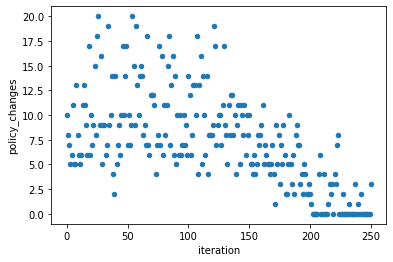

In [37]:
lake_ql_iter_df = lake_ql.iteration_data.to_dataframe()
lake_ql_iter_df.plot(x='iteration', y='policy_changes', kind='scatter', )

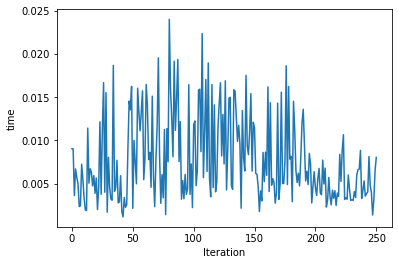

In [38]:
ax = plotting.plot_solver_convergence(lake_ql, y='time', label='ql')

In [39]:
lake_ql_intermediate_scoring_df = lake_ql.scoring_summary.to_dataframe()
lake_ql_intermediate_scoring_df

,iteration,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max
0,50,-1.34400,-1.35,0.356607,-1.99,0.72,46.348,41.0,25.226076,10,101
1,100,-1.28872,-1.00,0.361349,-1.99,0.40,81.172,101.0,26.601023,8,101
2,150,0.01412,0.44,0.768153,-1.88,0.82,64.268,57.5,29.380337,15,101
3,200,0.75404,0.81,0.321279,-1.94,0.87,22.596,21.0,7.600578,15,96
4,250,0.78992,0.82,0.192481,-1.30,0.87,21.408,20.0,4.555605,15,40


Text(0.5, 1.0, 'Mean Reward vs Iteration (Q-Learning)')

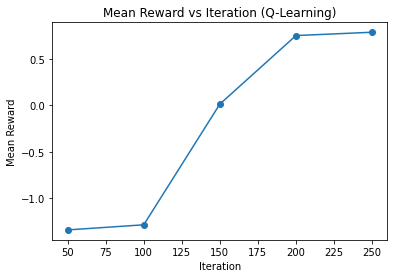

In [40]:
plt.plot(lake_ql_intermediate_scoring_df.loc[:, 'iteration'], lake_ql_intermediate_scoring_df.loc[:, 'reward_mean'], '-o')
plt.xlabel("Iteration")
plt.ylabel("Mean Reward")
plt.title("Mean Reward vs Iteration (Q-Learning)")

In [41]:
i = 200
print(f'EpisodeStatistics for the scoring at iter == {i}:\n')
lake_ql.scoring_episode_statistics[i].to_dataframe().head()

EpisodeStatistics for the scoring at iter == 200:



,episode_index,reward,steps,terminal,reward_mean,reward_median,reward_std,reward_min,reward_max,steps_mean,steps_median,steps_std,steps_min,steps_max,terminal_fraction
0,0,0.81,21,True,0.810000,0.810,0.000000,0.81,0.81,21.000000,21.0,0.000000,21,21,1.0
1,1,0.73,29,True,0.770000,0.770,0.040000,0.73,0.81,25.000000,25.0,4.000000,21,29,1.0
2,2,0.76,26,True,0.766667,0.760,0.032998,0.73,0.81,25.333333,26.0,3.299832,21,29,1.0
3,3,0.75,27,True,0.762500,0.755,0.029475,0.73,0.81,25.750000,26.5,2.947457,21,29,1.0
4,4,0.79,23,True,0.768000,0.760,0.028566,0.73,0.81,25.200000,26.0,2.856571,21,29,1.0


Text(0.5, 1.0, 'Reward vs Iteration (Q-Learning)')

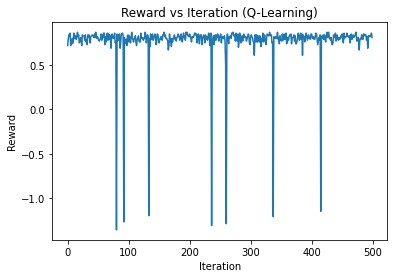

In [42]:
plt.plot(lake_ql.score_policy().rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration (Q-Learning)")

Text(0.5, 1.0, 'Reward vs Iteration (Policy Iteration)')

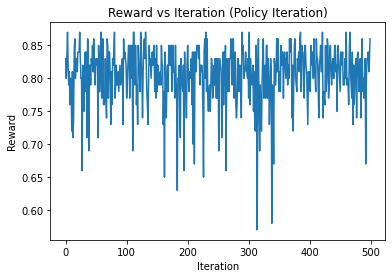

In [43]:
plt.plot(lake_pi.score_policy().rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration (Policy Iteration)")

Text(0.5, 1.0, 'Reward vs Iteration (Value Iteration)')

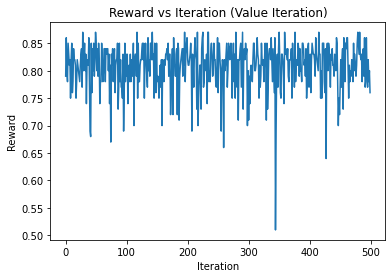

In [44]:
plt.plot(lake_vi.score_policy().rewards)
plt.xlabel("Iteration")
plt.ylabel("Reward")
plt.title("Reward vs Iteration (Value Iteration)")